## 0. 라이브러리

In [1]:
# %pip install statsmodels

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
import matplotlib.pyplot as plt

# 한글 폰트 지정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

[참고내용]  

- [VAR 모형 분석관련 블로그(1)](https://m.blog.naver.com/jiyong615/222141390514)  

- [VAR 모형 분석관련 블로그(2)](https://songseungwon.tistory.com/133)  


## 1. 데이터 불러오기

In [4]:
# df = pd.read_excel('score_ver1.xlsx', index_col='Year', parse_dates=True)
df = pd.read_excel('score_regress.xlsx', index_col='Year', parse_dates=True)

In [5]:
df.shape

(30, 5)

30년간의 연도 / 26개의 변수(이때 연도와 종속변수인 출산률도 포함됨)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1993-01-01 to 2022-01-01
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   합계출산율    30 non-null     float64
 1   경제 요인    30 non-null     float64
 2   부동산 요인   30 non-null     float64
 3   정서 요인    30 non-null     float64
 4   육아휴직 요인  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [7]:
df.head()

,합계출산율,경제 요인,부동산 요인,정서 요인,육아휴직 요인
Year,,,,,
1993-01-01,1.654,-1.6875,0.0018,-1.1548,-0.7484
1994-01-01,1.656,-1.5743,-0.0864,-0.9759,-0.3127
1995-01-01,1.634,-1.3991,-0.6061,-0.5739,0.0618
1996-01-01,1.574,-1.0474,-1.8639,-1.7371,0.4846
1997-01-01,1.537,-1.1861,-0.2737,-1.0955,-0.7512


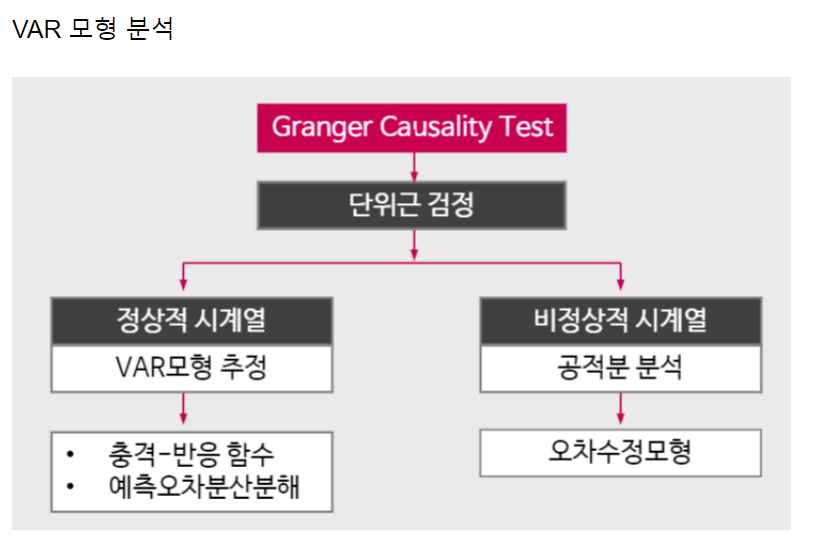

## Granger causality test (그랜저 인과관계 검정)

VAR 예측을 수행하기 전에 해당 변수들이 모두 상호연관성이 있는가를 확인 

Granger 인과검정의 영가설(귀무가설)은 X가 Y에 영향을 미치지 않는다 이다.   
즉, 검정 결과 p_value가 유의수준 0.05 이하라면 영가설(귀무가설)을 기각하고 해당 변수를 예측모델의 인자로 사용하도록 함  

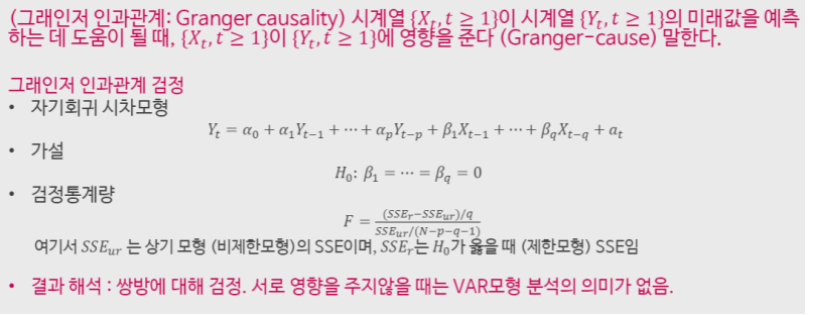

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(dataframe, dependent_var, max_lags=4):
    variables = dataframe.columns.drop(dependent_var)
    for var in variables:
        print(f"\nGranger Causality Test: {dependent_var} ~ {var}")
        test_result = grangercausalitytests(dataframe[[dependent_var, var]], maxlag=max_lags, verbose=True)

# '합계출산율'을 종속변수로 설정하여 그랜저 인과관계 검정 수행
granger_test(df, '합계출산율', max_lags=9)


Granger Causality Test: 합계출산율 ~ 경제 요인

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0201  , p=0.8884  , df_denom=26, df_num=1
ssr based chi2 test:   chi2=0.0224  , p=0.8810  , df=1
likelihood ratio test: chi2=0.0224  , p=0.8811  , df=1
parameter F test:         F=0.0201  , p=0.8884  , df_denom=26, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5507  , p=0.0216  , df_denom=23, df_num=2
ssr based chi2 test:   chi2=11.0801 , p=0.0039  , df=2
likelihood ratio test: chi2=9.3354  , p=0.0094  , df=2
parameter F test:         F=4.5507  , p=0.0216  , df_denom=23, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5946  , p=0.0133  , df_denom=20, df_num=3
ssr based chi2 test:   chi2=18.6080 , p=0.0003  , df=3
likelihood ratio test: chi2=14.1546 , p=0.0027  , df=3
parameter F test:         F=4.5946  , p=0.0133  , df_denom=20, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F tes

F test, 카이제곱 등의 여러 검정통계량 결과값을 보여줌   
여기서 카이제곱 통계량만 사용하여 진행  

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(dataframe, dependent_var, max_lags):
    variables = dataframe.columns.drop(dependent_var)  # 종속 변수를 제외한 나머지 변수들 선택
    for var in variables:
        print(f"\nGranger Causality Test: {dependent_var} ~ {var}")
        test_result = grangercausalitytests(dataframe[[dependent_var, var]], maxlag=max_lags, verbose=False)
        for lag in range(1, max_lags + 1):
            try:
                chi2 = test_result[lag][0]['ssr_chi2test'][0]  # 카이제곱 통계량
                p = test_result[lag][0]['ssr_chi2test'][1]  # p-value
                print(f"Lag {lag}: chi2={chi2:.4f}, p={p:.4f}")
            except IndexError:
                print(f"Lag {lag}: 결과 없음")

# 데이터 프레임 'df'와 '합계출산율'을 종속변수로 설정하여 Granger 인과관계 검정 수행
granger_test(df, '합계출산율', max_lags=9)



Granger Causality Test: 합계출산율 ~ 경제 요인
Lag 1: chi2=0.0224, p=0.8810
Lag 2: chi2=11.0801, p=0.0039
Lag 3: chi2=18.6080, p=0.0003
Lag 4: chi2=20.1769, p=0.0005
Lag 5: chi2=44.1414, p=0.0000
Lag 6: chi2=53.5584, p=0.0000
Lag 7: chi2=61.4045, p=0.0000
Lag 8: chi2=57.6039, p=0.0000
Lag 9: chi2=105.9475, p=0.0000

Granger Causality Test: 합계출산율 ~ 부동산 요인
Lag 1: chi2=5.2688, p=0.0217
Lag 2: chi2=9.3199, p=0.0095
Lag 3: chi2=19.4766, p=0.0002
Lag 4: chi2=14.3617, p=0.0062
Lag 5: chi2=24.1610, p=0.0002
Lag 6: chi2=26.3361, p=0.0002
Lag 7: chi2=38.6385, p=0.0000
Lag 8: chi2=50.5742, p=0.0000
Lag 9: chi2=134.6670, p=0.0000

Granger Causality Test: 합계출산율 ~ 정서 요인
Lag 1: chi2=4.3311, p=0.0374
Lag 2: chi2=4.8925, p=0.0866
Lag 3: chi2=6.5375, p=0.0882
Lag 4: chi2=6.2067, p=0.1842
Lag 5: chi2=12.4445, p=0.0292
Lag 6: chi2=14.0305, p=0.0293
Lag 7: chi2=19.2349, p=0.0075
Lag 8: chi2=60.1103, p=0.0000
Lag 9: chi2=135.3205, p=0.0000

Granger Causality Test: 합계출산율 ~ 육아휴직 요인
Lag 1: chi2=0.9318, p=0.3344
Lag 2:

영향력이 있는지에 대해서 보고싶은것으로  
결과만 출력하도록 코드를 작성  

즉, 결과자체는 아래의 내용의 코드만 보면 됨

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test_no_relationship(dataframe, dependent_var, max_lags=9, p_value_threshold=0.05):
    variables = dataframe.columns.drop(dependent_var)  # 종속 변수를 제외한 나머지 변수들 선택
    no_relationship_count = 0  # 관계가 없는 변수의 수를 셉니다
    
    for var in variables:
        no_relationship = True  # 처음에는 관계가 없다고 가정합니다
        test_result = grangercausalitytests(dataframe[[dependent_var, var]], maxlag=max_lags, verbose=False)
        for lag in range(1, max_lags + 1):
            chi2, p, *_ = test_result[lag][0]['ssr_chi2test']  # 카이제곱 통계량과 p-value를 추출합니다
            if p < p_value_threshold:  # p-value가 임계값보다 작으면, 즉 통계적으로 유의미하면
                no_relationship = False  # 관계가 있다고 결론짓습니다
                break  # 적어도 하나의 유의미한 관계가 있으면 반복을 중단합니다
        if no_relationship:  # 만약 모든 지연에 대해 관계가 없다면
            no_relationship_count += 1  # 관계가 없는 변수의 수를 증가시킵니다
            print(f"\nGranger Causality Test: {dependent_var} ~ {var}")
            print("The variable has no relationship.")

    if no_relationship_count == 0:  # 만약 관계가 없는 변수가 하나도 없다면
        print("\n모든 변수가 종속 변수와 통계적으로 유의미한 관계를 가지고 있습니다.")

# 데이터 프레임 'df'와 '합계출산율'을 종속변수로 설정하여 Granger 인과관계 검정 수행
granger_test_no_relationship(df, '합계출산율', max_lags=8)


모든 변수가 종속 변수와 통계적으로 유의미한 관계를 가지고 있습니다.


In [11]:
# 데이터프레임으로 출력 -> 변수량이 많아서 가시적으로 좋지 않음

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# 데이터 프레임 df 및 변수 목록 df_cols 생성
df = df
df_cols = df.columns

# df_pairs 데이터 프레임 초기화
df_pairs = pd.DataFrame(data=np.zeros((len(df_cols), len(df_cols))),
                        columns=['X_' + x for x in df_cols],
                        index=['Y_' + x for x in df_cols])

maxlag = 9  # 최대 지연 시간 설정

# 모든 변수 쌍에 대해 Granger 인과관계 검정 수행
for col_i, col in enumerate(df_cols):
    for idx_i, idx in enumerate(df_cols):
        if col != idx:  # 동일 변수끼리의 비교는 제외
            outs = grangercausalitytests(df[[col, idx]], maxlag=maxlag, verbose=False)
            pval_min = np.min([outs[x][0]['ssr_chi2test'][1] for x in range(1, maxlag+1)])
        else:
            pval_min = np.nan  # 동일 변수 비교 시 NaN으로 설정
        df_pairs.iloc[idx_i, col_i] = pval_min

# 결과 출력
df_pairs = df_pairs.round(4) # 소수 네 번째 자리까지 반올림
df_pairs


,X_합계출산율,X_경제 요인,X_부동산 요인,X_정서 요인,X_육아휴직 요인
Y_합계출산율,NaN,0.0,0.0,0.0,0.0
Y_경제 요인,0.0,NaN,0.0,0.0,0.0
Y_부동산 요인,0.0,0.0,NaN,0.0,0.0
Y_정서 요인,0.0,0.0,0.0,NaN,0.0
Y_육아휴직 요인,0.0,0.0,0.0,0.0,NaN


## 정상성 검정

연도에 따른 각 변수별 추세 시각화

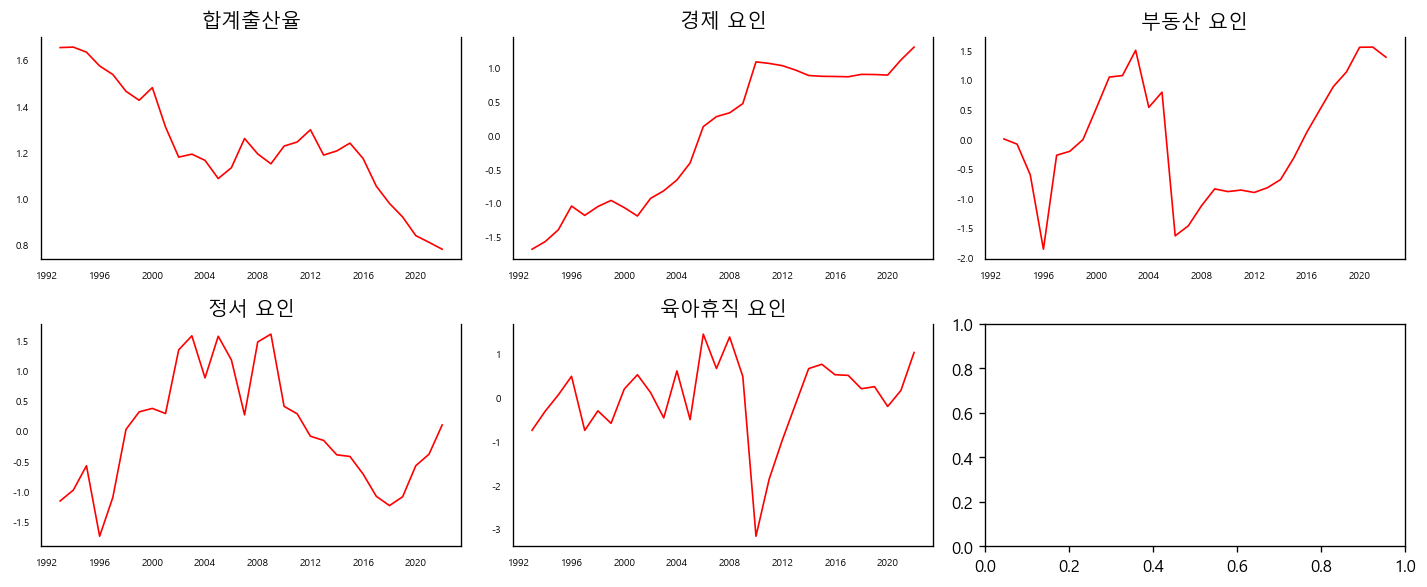

In [12]:
# Plot and visualize
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,5))
for i, ax in enumerate(axes.flatten()):
    if i < len(df.columns):
        data = df[df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

plt.tight_layout()

- Augmented Dickey-Fuller (ADF) test  
추세를 포함하는 시계열 데이터에 대해서도 단위근 검정을 실시해주는 방법론  
Dickey-Fuller(DF) 검정을 더욱 일반화시킨 방식

In [13]:
def adf_test(series, signif=0.05, name=''):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    
    # 정상성 검정 결과 출력
    print("\n   ", '-'*47)
    print(f'    Augmented Dickey-Fuller Test on "{name}"')
    if p_value <= signif:
        print(f" => P-Value = {p_value}. 귀무가설 기각.")
        print(f" => 시계열은 정상 시계열입니다.")
    else:
        print(f" => P-Value = {p_value}. 귀무가설 기각에 대한 근거 부족.")
        print(f" => 시계열은 비정상 시계열입니다.")

# 각 변수에 대한 ADF 테스트 수행
for name, column in df.iteritems():
    adf_test(column, name=name)



    -----------------------------------------------
    Augmented Dickey-Fuller Test on "합계출산율"
 => P-Value = 0.8785. 귀무가설 기각에 대한 근거 부족.
 => 시계열은 비정상 시계열입니다.

    -----------------------------------------------
    Augmented Dickey-Fuller Test on "경제 요인"
 => P-Value = 0.7166. 귀무가설 기각에 대한 근거 부족.
 => 시계열은 비정상 시계열입니다.

    -----------------------------------------------
    Augmented Dickey-Fuller Test on "부동산 요인"
 => P-Value = 0.3231. 귀무가설 기각에 대한 근거 부족.
 => 시계열은 비정상 시계열입니다.

    -----------------------------------------------
    Augmented Dickey-Fuller Test on "정서 요인"
 => P-Value = 0.052. 귀무가설 기각에 대한 근거 부족.
 => 시계열은 비정상 시계열입니다.

    -----------------------------------------------
    Augmented Dickey-Fuller Test on "육아휴직 요인"
 => P-Value = 0.0101. 귀무가설 기각.
 => 시계열은 정상 시계열입니다.


차분을 통해 비정상시계열 -> 정상시계열

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# ADF 검정을 수행하는 함수
def adf_test(series, signif=0.05):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags': round(r[2], 4), 'n_obs': r[3]}
    p_value = output['pvalue']
    is_stationary = p_value <= signif
    return is_stationary, p_value

# 차분과 ADF 검정을 반복하는 함수
def differencing_and_adf(df, max_differencing=10):
    differenced_data = {}
    for name, column in df.iteritems():
        is_stationary, p_value = adf_test(column)
        differencing_count = 0
        
        while not is_stationary and differencing_count < max_differencing:
            column = column.diff().dropna()
            is_stationary, p_value = adf_test(column)
            differencing_count += 1
            
        differenced_data[f"{name}_diff{differencing_count if differencing_count > 0 else ''}"] = column
        print(f"{name}: 차분 횟수 = {differencing_count}, P-Value = {p_value}, 정상 시계열 여부 = {'정상' if is_stationary else '비정상'}")
        
    return pd.DataFrame(differenced_data)

# 차분과 ADF 검정 실행
df_diff = differencing_and_adf(df)


합계출산율: 차분 횟수 = 1, P-Value = 0.0001, 정상 시계열 여부 = 정상
경제 요인: 차분 횟수 = 1, P-Value = 0.0004, 정상 시계열 여부 = 정상
부동산 요인: 차분 횟수 = 1, P-Value = 0.0, 정상 시계열 여부 = 정상
정서 요인: 차분 횟수 = 3, P-Value = 0.0012, 정상 시계열 여부 = 정상
육아휴직 요인: 차분 횟수 = 0, P-Value = 0.0101, 정상 시계열 여부 = 정상


비정상시계열 -> 정상시계열로 변환한 변수들에 대해서 추세 시각화

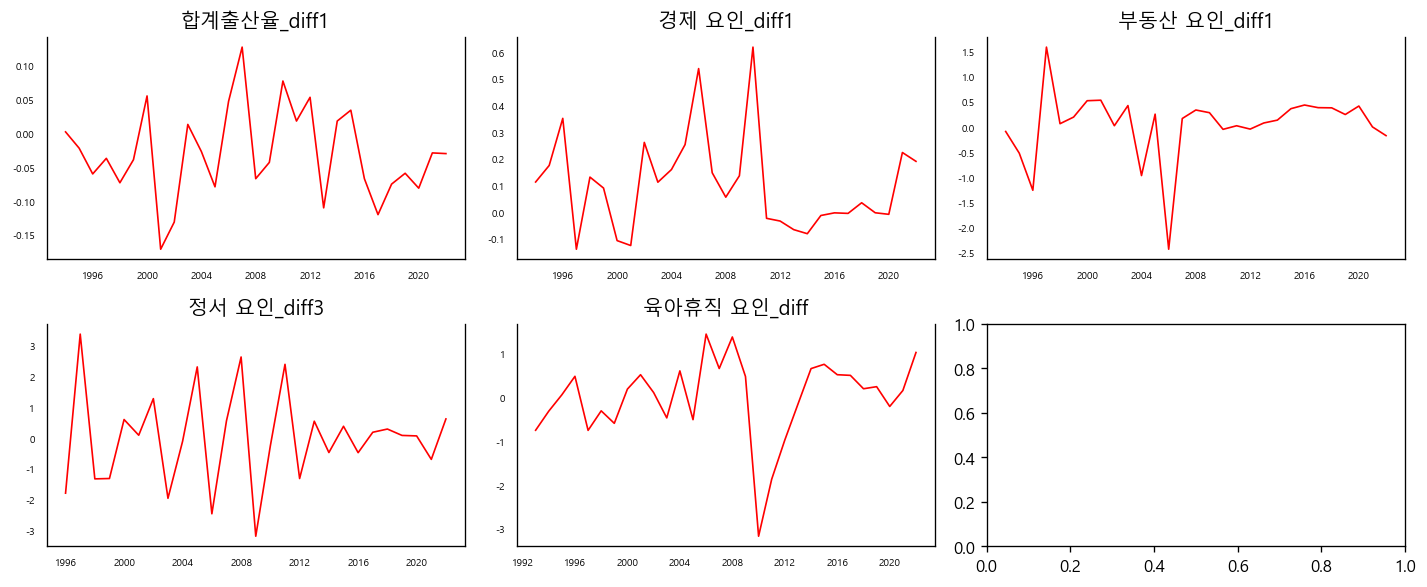

In [15]:
# Plot and visualize
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,5))
for i, ax in enumerate(axes.flatten()):
    if i < len(df_diff.columns):
        data = df_diff[df_diff.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df_diff.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

plt.tight_layout()

In [16]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1993-01-01 to 2022-01-01
Freq: AS-JAN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   합계출산율_diff1   29 non-null     float64
 1   경제 요인_diff1   29 non-null     float64
 2   부동산 요인_diff1  29 non-null     float64
 3   정서 요인_diff3   27 non-null     float64
 4   육아휴직 요인_diff  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


시계열 데이터가 얼마나 자주 발생하는지 지정  
빈도 - 연간, 분기, 월간, 주간, 일간 등으로 표시  

In [17]:
df_diff = df_diff.asfreq('AS-JAN') # 'AS-JAN'은 매년 1월 시작을 의미하는 연간 빈도

In [18]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1993-01-01 to 2022-01-01
Freq: AS-JAN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   합계출산율_diff1   29 non-null     float64
 1   경제 요인_diff1   29 non-null     float64
 2   부동산 요인_diff1  29 non-null     float64
 3   정서 요인_diff3   27 non-null     float64
 4   육아휴직 요인_diff  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [19]:
# 결측치 제거
df_diff = df_diff.dropna()

In [20]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 1996-01-01 to 2022-01-01
Freq: AS-JAN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   합계출산율_diff1   27 non-null     float64
 1   경제 요인_diff1   27 non-null     float64
 2   부동산 요인_diff1  27 non-null     float64
 3   정서 요인_diff3   27 non-null     float64
 4   육아휴직 요인_diff  27 non-null     float64
dtypes: float64(5)
memory usage: 1.3 KB


다변량 시계열 분석에서 각 독립변수의 최적 시차(lag)가 서로 다를 수 있음  
그러나 VAR(Vector Autoregression) 모델은 모든 변수에 대해 같은 시차를 사용  

이는 모델의 한계 중 하나로,  
실제로 각 변수가 서로 다른 시차에서 서로에게 영향을 미칠 수 있음에도 불구하고,  
모델은 모든 변수에 대해 동일한 시차를 적용  

대안중 하나로 VARMAX 모델 고려할수 있음    
VARMAX 모델은 외생 변수를 포함하고, 이동 평균 구성 요소를 추가하여 더 유연한 모델링  

In [21]:
model = VAR(df_diff)

# 최대 시차를 관측치 수에 적합하게 조정(최대 3년을 넘어가면 에러 발생)
lag_order_results = model.select_order(3)  # 예시로 최대 3 시차까지 검토

print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -9.715      -9.470   6.037e-05      -9.650
1      -11.15      -9.673   1.524e-05      -10.76
2      -11.77      -9.070   1.119e-05      -11.05
3     -13.88*     -9.957*  3.714e-06*     -12.84*
-------------------------------------------------


## VAR 모형 추정

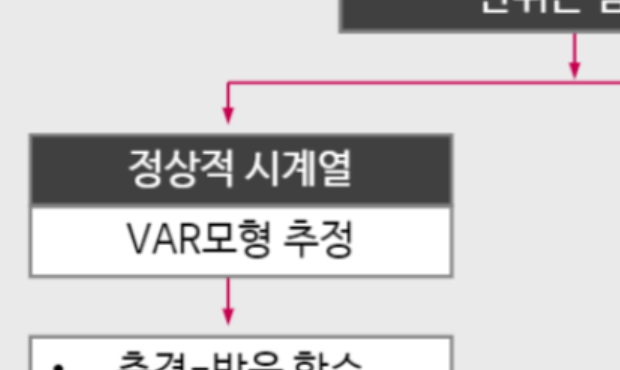

In [22]:
model = VAR(df_diff)

selected_lag = lag_order_results.aic  # AIC를 기준으로 최적의 시차 선택
model_fitted = model.fit(selected_lag)

# model_fitted = model.fit(2)  # 시차를 직접 선택도 가능 (예시로 2 시차 선택)

print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     13:10:39
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -9.95718
Nobs:                     24.0000    HQIC:                  -12.8422
Log likelihood:           76.3357    FPE:                3.71361e-06
AIC:                     -13.8840    Det(Omega_mle):     2.88770e-07
--------------------------------------------------------------------
Results for equation 합계출산율_diff1
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.028232         0.061925           -0.456           0.648
L1.합계출산율_diff1         -0.127223         0.352084           -0.361           0.718
L1.경제 요인_diff1          0.045812         0.270

합계출산율에 대해서만 확인을 위해서 코드 재작성  
(위의 결과값과 동일)

In [23]:
import statsmodels.tsa.api as smt

# 데이터프레임 df_diff 대해 VAR 모델을 적합
model = smt.VAR(df_diff)
selected_lag = lag_order_results.aic  # AIC를 기준으로 최적의 시차를 선택
model_fitted = model.fit(selected_lag)

# '합계출산율'과 관련된 결과만 필터링
# model_fitted.params 에서 '합계출산율'에 대한 계수 추출
fertility_rate_coefficients = model_fitted.params['합계출산율_diff1']

# model_fitted.stderr 에서 '합계출산율'에 대한 표준 오차 추출
fertility_rate_std_errors = model_fitted.stderr['합계출산율_diff1']

# model_fitted.tvalues 에서 '합계출산율'에 대한 t-통계량 추출
fertility_rate_t_stats = model_fitted.tvalues['합계출산율_diff1']

# model_fitted.pvalues 에서 '합계출산율'에 대한 p-값 추출
fertility_rate_p_values = model_fitted.pvalues['합계출산율_diff1']

# 결과를 데이터 프레임으로 조합
results_df = pd.DataFrame({
    'Coefficients': fertility_rate_coefficients,
    'Standard Errors': fertility_rate_std_errors,
    'T-Statistics': fertility_rate_t_stats,
    'P-Values': fertility_rate_p_values
})

# 결과 출력
results_df

,Coefficients,Standard Errors,T-Statistics,P-Values
const,-0.028232,0.061925,-0.455913,0.648453
L1.합계출산율_diff1,-0.127223,0.352084,-0.361343,0.717843
L1.경제 요인_diff1,0.045812,0.270999,0.169048,0.865759
L1.부동산 요인_diff1,-0.047104,0.075808,-0.621364,0.534360
L1.정서 요인_diff3,0.013917,0.028892,0.481694,0.630024
L1.육아휴직 요인_diff,-0.029810,0.043137,-0.691059,0.489528
L2.합계출산율_diff1,-0.181882,0.315625,-0.576261,0.564439
L2.경제 요인_diff1,0.323183,0.442498,0.730360,0.465170
L2.부동산 요인_diff1,0.029074,0.141370,0.205661,0.837056
L2.정서 요인_diff3,0.020947,0.023288,0.899461,0.368407


VAR 모형 구축됨!

## 충격반응함수(Impulse Response Function, IRF)

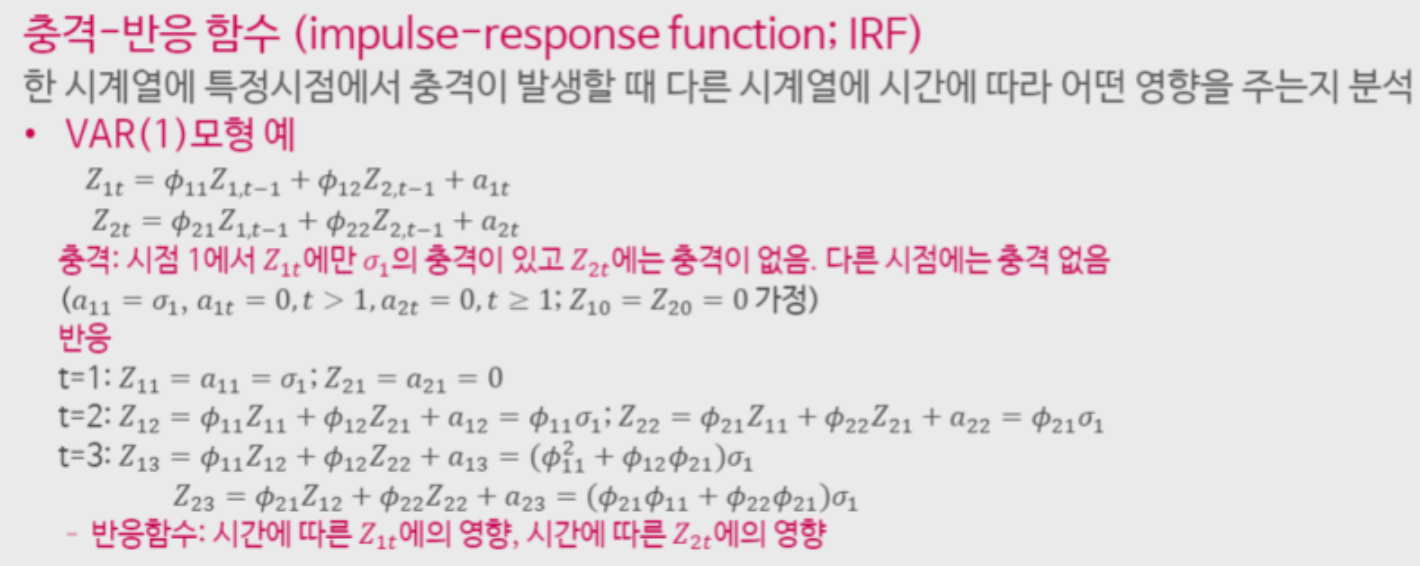

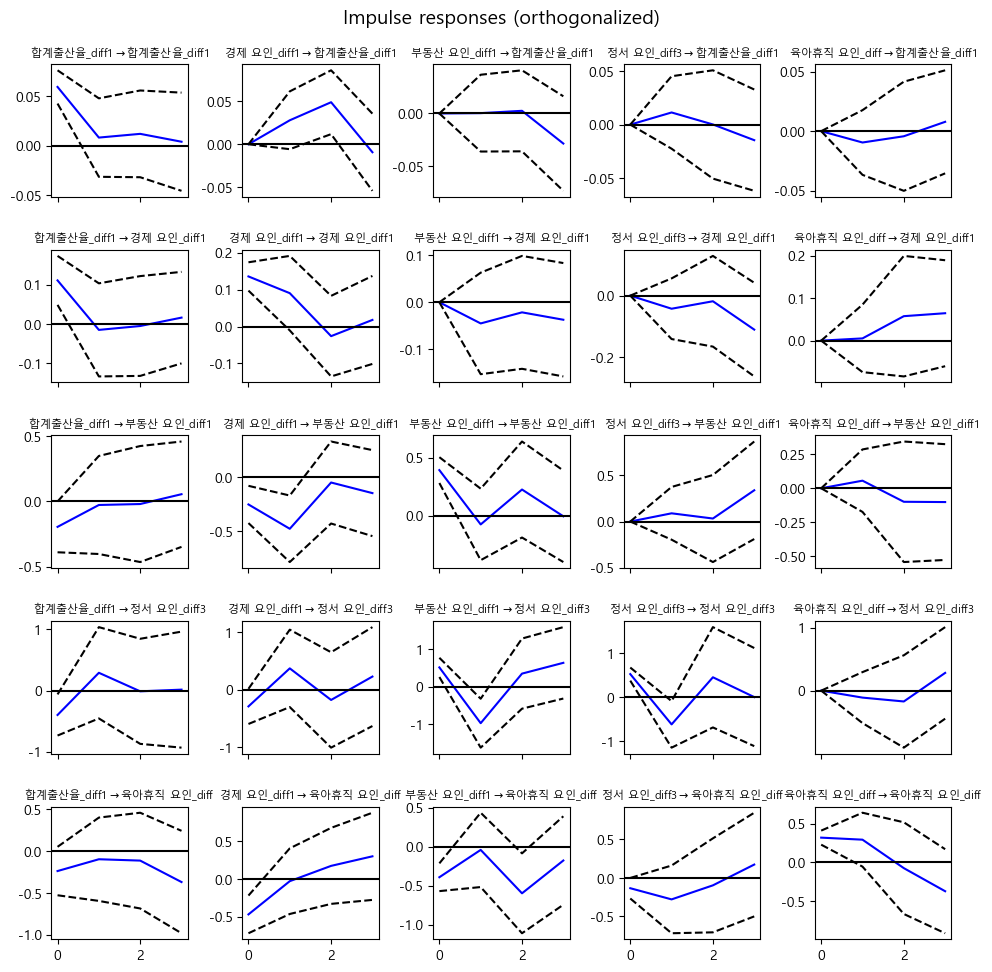

In [24]:
irf = model_fitted.irf(3)  # 최대 5년 동안의 IRF 계산가능
fig = irf.plot(orth=True)  # 직교화된 충격반응함수를 그래프로 표시

# 각 서브플롯의 제목 변경 및 회전
for ax in fig.axes:
    title = ax.get_title()
    new_title = title.split('->')[0].strip()  # '->' 기호를 기준으로 문자열 분리 후 첫 번째 부분만 사용
    ax.set_title(new_title, fontsize=8)  # 제목 크기를 8로 설정

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # 서브플롯 간의 수직 간격과 수평 간격 설정
plt.show()

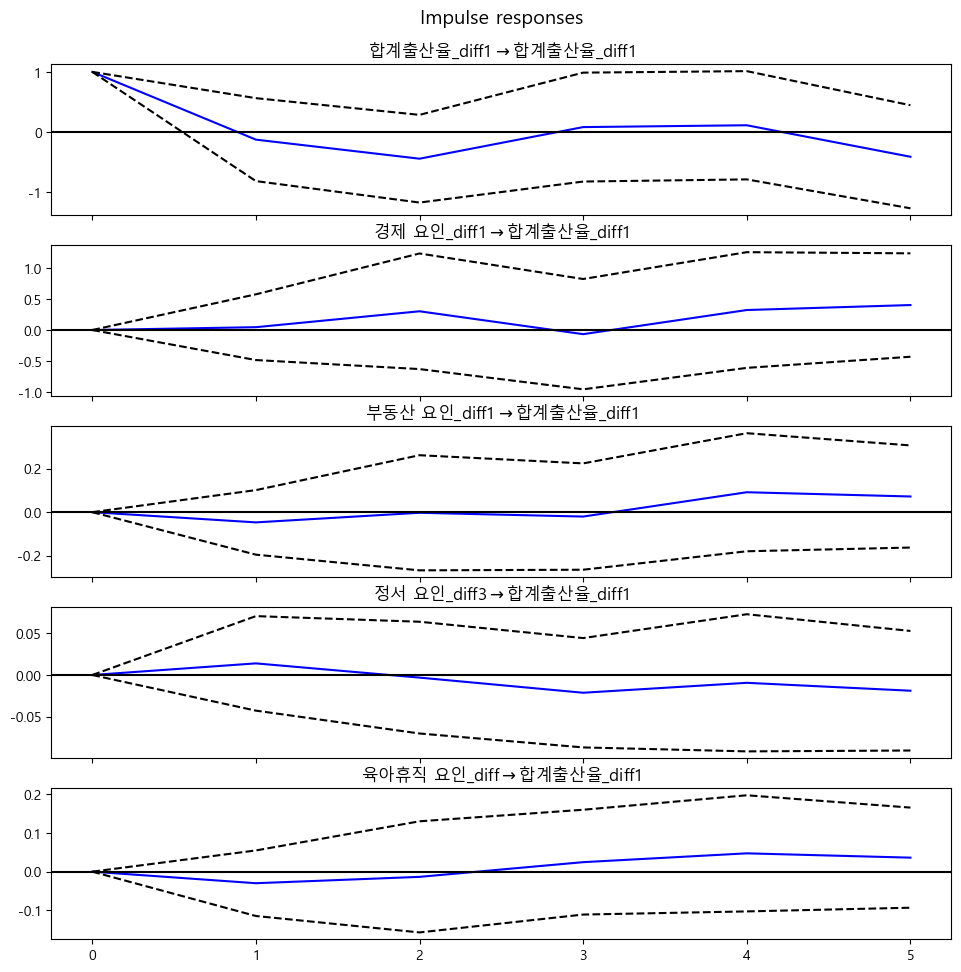

In [25]:
irf = model_fitted.irf(5)  # 최대 3단계 동안의 IRF 계산
fig = irf.plot(response='합계출산율_diff1')

## 예측오차 분산분해(Forecast Error Variance Decomposition, FEVD)

충격 반응 함수(Impulse Response Function, IRF)와 예측 오차 분산 분해(Forecast Error Variance Decomposition, FEVD)는  
모두 벡터 자기회귀(VAR) 모델에서 시계열 데이터의 동적 상호작용을 분석하는 데 사용되는 도구입니다.  
두 개념은 서로 관련이 있지만, 다른 정보를 제공합니다.

충격 반응 함수(IRF): IRF는 시스템 내의 한 변수에 대한 '충격'(즉, 예상치 못한 한 단위 변화)이 시간이 지남에 따라 다른 변수에  
어떤 영향을 미치는지를 보여줍니다. 예를 들어, 통화 정책의 변화가 경제에 어떤 영향을 미치는지를 분석할 수 있습니다.

예측 오차 분산 분해(FEVD): FEVD는 시스템 내의 각 변수가 다른 변수의 예측 오차에 얼마나 기여하는지를 보여줍니다.  
즉, 한 변수의 예측 오차가 시간이 지남에 따라 다른 변수의 '충격'에 의해 얼마나 설명되는지를 보여줍니다.

따라서, IRF는 '충격'이 시간이 지남에 따라 어떻게 전파되는지를 보여주고, FEVD는 이러한 '충격'이 예측 오차에 얼마나  
기여하는지를 보여줍니다. 이 두 가지 도구를 함께 사용하면, 시계열 데이터의 복잡한 동적 상호작용을 더 잘 이해할 수 있습니다

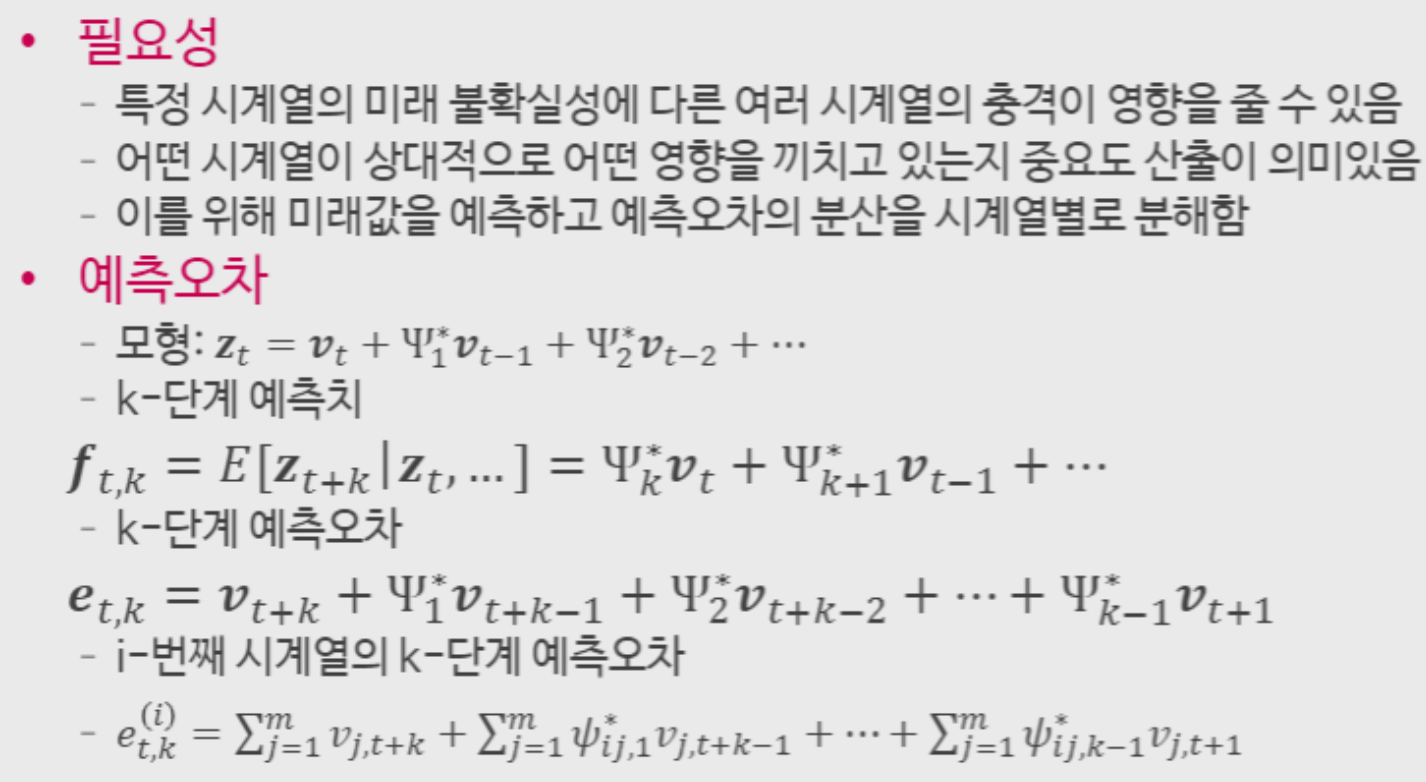

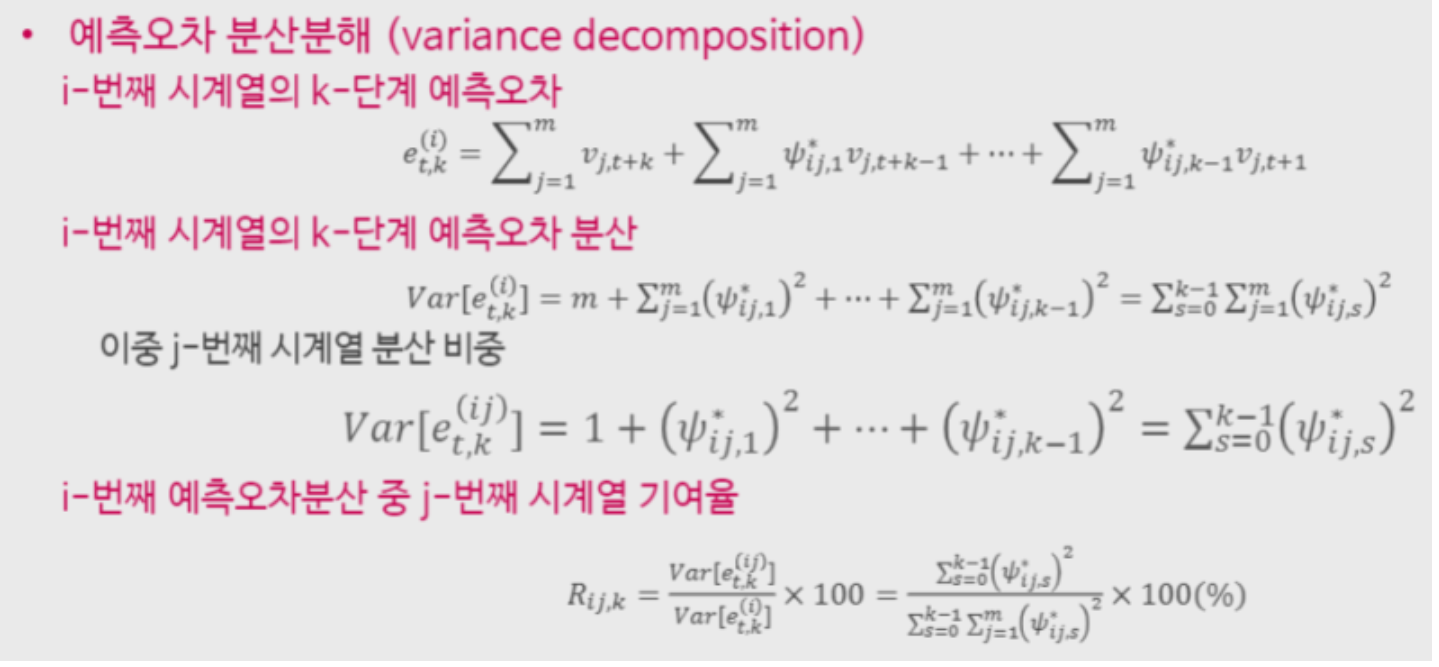

In [26]:
fevd = model_fitted.fevd(10)  # 10기간 동안의 FEVD 계산
fevd.summary()  # FEVD 결과 요약 출력

FEVD for 합계출산율_diff1
     합계출산율_diff1  경제 요인_diff1  부동산 요인_diff1  정서 요인_diff3  육아휴직 요인_diff
0       1.000000     0.000000      0.000000     0.000000      0.000000
1       0.784211     0.168078      0.000022     0.027960      0.019729
2       0.525026     0.440797      0.000904     0.018001      0.015272
3       0.452424     0.388471      0.097969     0.040671      0.020465
4       0.443927     0.354454      0.106938     0.051063      0.043618
5       0.401509     0.380559      0.098155     0.067434      0.052343
6       0.422173     0.338712      0.132861     0.059817      0.046438
7       0.412120     0.351438      0.132378     0.058789      0.045275
8       0.409898     0.349695      0.131287     0.063529      0.045591
9       0.414221     0.345252      0.134137     0.062027      0.044363

FEVD for 경제 요인_diff1
     합계출산율_diff1  경제 요인_diff1  부동산 요인_diff1  정서 요인_diff3  육아휴직 요인_diff
0       0.401588     0.598412      0.000000     0.000000      0.000000
1       0.292581     0.617110     

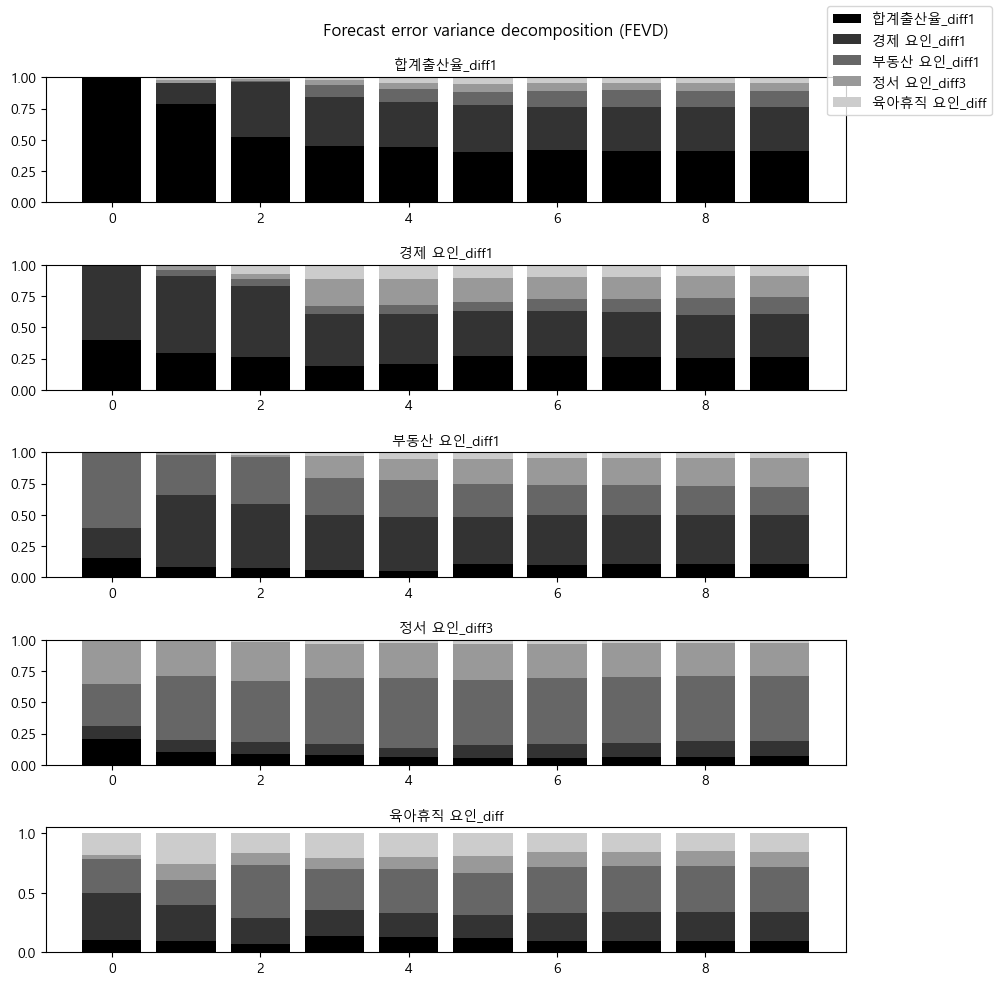

In [27]:
fevd = model_fitted.fevd(10)  # 예측오차 분산분해 수행 / 10 -> 분해를 수행하는 기간
fig = fevd.plot(0)  # 합계출산율에 대한 예측오차 분산분해 결과 시각화 / 0 -> 합계출산율에 대한 분해 결과만 표시

# 각 서브플롯의 제목 크기 변경
for ax in fig.axes:
    title = ax.get_title()
    ax.set_title(title, fontsize=10)  # 제목 크기를 14로 설정

plt.subplots_adjust(hspace=0.5)  # 서브플롯 간의 수직 간격 설정
plt.show()

y축은 분산의 비율을 나타내며, x축은 시간 (기간)을 나타냅니다.

특정 시점에서의 영향력 분석

In [28]:
# 5기간 후의 예측오차 분산분해 결과 가져오기
fevd_5 = fevd.decomp[2] # 인덱스는 0부터 시작하므로 3기간 후는 인덱스 4에 해당

# 합계출산율(예시로 0번째 변수라 가정)에 대한 각 변수의 기여도 출력
print("3기간 후 합계출산율 변동성에 대한 각 변수의 기여도:")
for i, var in enumerate(df_diff.columns):
    print(f"{var}: {fevd_5[0, i]:.4f}")

3기간 후 합계출산율 변동성에 대한 각 변수의 기여도:
합계출산율_diff1: 0.1503
경제 요인_diff1: 0.2440
부동산 요인_diff1: 0.6057
정서 요인_diff3: 0.0000
육아휴직 요인_diff: 0.0000


In [29]:
# 5기간 후의 예측오차 분산분해 결과 가져오기
fevd_5 = fevd.decomp[4] # 인덱스는 0부터 시작하므로 5기간 후는 인덱스 4에 해당

# 합계출산율(예시로 0번째 변수라 가정)에 대한 각 변수의 기여도 출력
print("5기간 후 합계출산율 변동성에 대한 각 변수의 기여도:")
for i, var in enumerate(df_diff.columns):
    print(f"{var}: {fevd_5[0, i]:.4f}")


5기간 후 합계출산율 변동성에 대한 각 변수의 기여도:
합계출산율_diff1: 0.1033
경제 요인_diff1: 0.3982
부동산 요인_diff1: 0.2794
정서 요인_diff3: 0.0331
육아휴직 요인_diff: 0.1860


시간에 따른 영향력 변화 분석

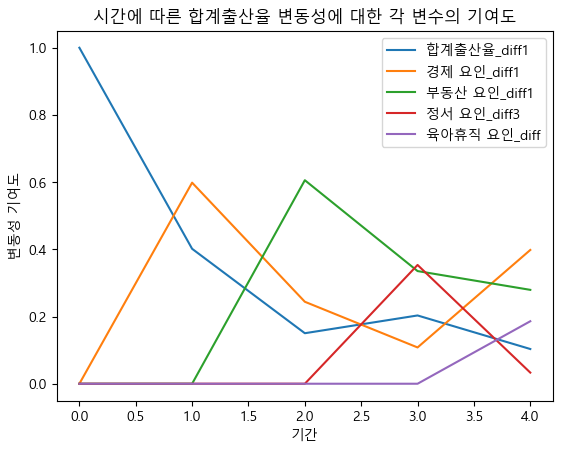

In [30]:
# 시간에 따른 합계출산율 변동성에 대한 각 변수의 기여도 그래프
for i, var in enumerate(df_diff.columns):
    plt.plot([fevd.decomp[j][0, i] for j in range(5)], label=var)

plt.title('시간에 따른 합계출산율 변동성에 대한 각 변수의 기여도', fontsize=12)  # 제목 크기를 12으로 설정
plt.xlabel('기간')
plt.ylabel('변동성 기여도')
plt.legend()
plt.show()

### VAR 모형 예측

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1993-01-01 to 2022-01-01
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   합계출산율    30 non-null     float64
 1   경제 요인    30 non-null     float64
 2   부동산 요인   30 non-null     float64
 3   정서 요인    30 non-null     float64
 4   육아휴직 요인  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [32]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 1996-01-01 to 2022-01-01
Freq: AS-JAN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   합계출산율_diff1   27 non-null     float64
 1   경제 요인_diff1   27 non-null     float64
 2   부동산 요인_diff1  27 non-null     float64
 3   정서 요인_diff3   27 non-null     float64
 4   육아휴직 요인_diff  27 non-null     float64
dtypes: float64(5)
memory usage: 1.3 KB


In [33]:
import pandas as pd
from statsmodels.tsa.api import VAR

# 데이터 준비
# df_diff는 이미 차분된 데이터프레임입니다.
# 여기서 df_diff로 VAR 모형을 구축합니다.

# 최적의 차수 선택
model = VAR(df_diff)
lag_order = model.select_order()
print(lag_order.summary())

# AIC, BIC 등의 정보를 바탕으로 최적의 차수를 선택
# 예를 들어, lag_order.aic에서 가장 낮은 차수를 선택할 수 있습니다.
optimal_lag = lag_order.aic

# 모형 적합
var_model = model.fit(optimal_lag)
print(var_model.summary())



 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -9.715      -9.470   6.037e-05      -9.650
1      -11.15      -9.673   1.524e-05      -10.76
2      -11.77      -9.070   1.119e-05      -11.05
3     -13.88*     -9.957*  3.714e-06*     -12.84*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     13:10:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -9.95718
Nobs:                     24.0000    HQIC:                  -12.8422
Log likelihood:           76.3357    FPE:                3.71361e-06
AIC:                     -13.8840    Det(Omega_mle):     2.88770e-07
--------------------------------------------------------------------
Results for

In [34]:
# 예측 (3년 = 3개의 기간 예측)
forecast_steps = 3
forecast = var_model.forecast(df_diff.values[-optimal_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='AS-JAN')[1:], columns=df_diff.columns)

print(forecast_df)

            합계출산율_diff1  경제 요인_diff1  부동산 요인_diff1  정서 요인_diff3  육아휴직 요인_diff
2023-01-01    -0.006422     0.167755     -0.240200    -1.541382      0.417307
2024-01-01    -0.028611     0.420347     -0.596226     1.434111     -0.915833
2025-01-01     0.021338     0.194908     -0.257373     0.613841     -0.309393


In [35]:
# 예측된 합계출산율 출력
predicted_total_fertility_rate = forecast_df['합계출산율_diff1'].cumsum() + df['합계출산율'].iloc[-1]
print("--- 22년도 이후 3년 기간 예측한 합계출산율 ---")
print(predicted_total_fertility_rate)


--- 22년도 이후 3년 기간 예측한 합계출산율 ---
2023-01-01    0.771578
2024-01-01    0.742967
2025-01-01    0.764305
Freq: AS-JAN, Name: 합계출산율_diff1, dtype: float64


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 1993-01-01 to 2022-01-01
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   합계출산율    30 non-null     float64
 1   경제 요인    30 non-null     float64
 2   부동산 요인   30 non-null     float64
 3   정서 요인    30 non-null     float64
 4   육아휴직 요인  30 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [37]:
df.tail()

,합계출산율,경제 요인,부동산 요인,정서 요인,육아휴직 요인
Year,,,,,
2018-01-01,0.977,0.9041,0.8860,-1.2314,0.2004
2019-01-01,0.918,0.9020,1.1352,-1.0856,0.2479
2020-01-01,0.837,0.8941,1.5530,-0.5722,-0.2043
2021-01-01,0.808,1.1178,1.5556,-0.3835,0.1612
2022-01-01,0.778,1.3084,1.3847,0.0998,1.0294


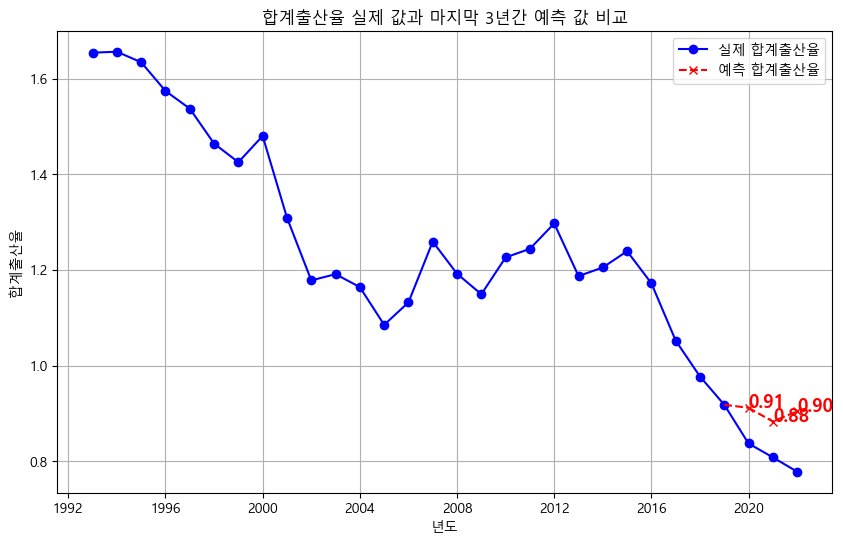

In [38]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(10, 6))

# 실제 합계출산율 데이터 시각화 (전체 데이터)
plt.plot(df.index, df['합계출산율'], label='실제 합계출산율', marker='o', color='blue')

# 예측된 합계출산율 데이터
# 예측된 합계출산율 데이터를 누적하여 시각화하기 위해 누적 차분을 계산합니다.
# 이때, 예측 시작점을 실제 데이터의 마지막 4번째 값에서 시작하게 합니다.
predicted_total_fertility_rate = forecast_df['합계출산율_diff1'][-3:].cumsum() + df['합계출산율'].iloc[-4]
predicted_dates = df.index[-3:]

# 예측된 값에 대해 수치 표시
for date, value in zip(predicted_dates, predicted_total_fertility_rate):
    plt.text(date, value, f"{value:.2f}", color='red', weight='bold',fontsize=13)
plt.plot(predicted_dates, predicted_total_fertility_rate, label='예측 합계출산율', marker='x', linestyle='--', color='red')

# 실제 값의 마지막 점과 예측 값의 시작하는 점을 이어주는 선 추가
plt.plot([df.index[-4], predicted_dates[0]], [df['합계출산율'].iloc[-4], predicted_total_fertility_rate[0]], color='red', linestyle='--')

# 실제 값과 예측 값의 비교를 위한 그래프 세부 설정
plt.title('합계출산율 실제 값과 마지막 3년간 예측 값 비교')
plt.xlabel('년도')
plt.ylabel('합계출산율')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()

In [39]:
import numpy as np
import pandas as pd

actual_values = np.array(df['합계출산율'][-3:])
predicted_values = np.array(predicted_total_fertility_rate)

# 0으로 나누는 것을 방지하기 위해 작은 수(epsilon)를 분모에 추가합니다.
epsilon = 1e-8
mape = np.mean(np.abs((actual_values - predicted_values) / (actual_values + epsilon))) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 11.47%


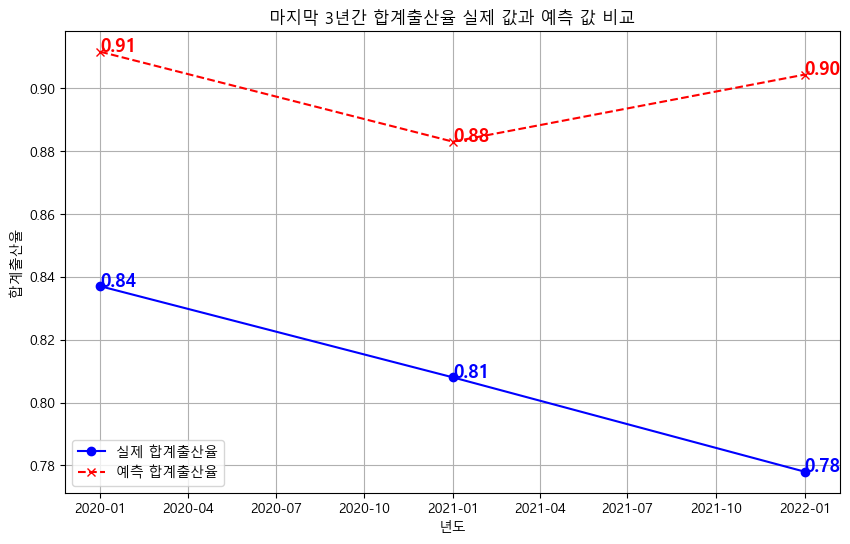

In [40]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(10, 6))

# 실제 합계출산율 데이터 시각화 (전체 데이터 중 마지막 3개 값)
plt.plot(df.index[-3:], df['합계출산율'][-3:], label='실제 합계출산율', marker='o', color='blue')

# 실제 값에 대해 수치 표시
for date, value in zip(df.index[-3:], df['합계출산율'][-3:]):
    plt.text(date, value, f"{value:.2f}", color='blue', weight='bold', fontsize=13)

# 예측된 합계출산율 데이터
# 예측된 합계출산율 데이터를 누적하여 시각화하기 위해 누적 차분을 계산합니다.
# 이때, 예측 시작점을 실제 데이터의 마지막 4번째 값에서 시작하게 합니다.
predicted_total_fertility_rate = forecast_df['합계출산율_diff1'][-3:].cumsum() + df['합계출산율'].iloc[-4]
predicted_dates = df.index[-3:]

# 예측된 값에 대해 수치 표시
for date, value in zip(predicted_dates, predicted_total_fertility_rate):
    plt.text(date, value, f"{value:.2f}", color='red', weight='bold', fontsize=13)
plt.plot(predicted_dates, predicted_total_fertility_rate, label='예측 합계출산율', marker='x', linestyle='--', color='red')

# 실제 값과 예측 값의 비교를 위한 그래프 세부 설정
plt.title('마지막 3년간 합계출산율 실제 값과 예측 값 비교')
plt.xlabel('년도')
plt.ylabel('합계출산율')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()

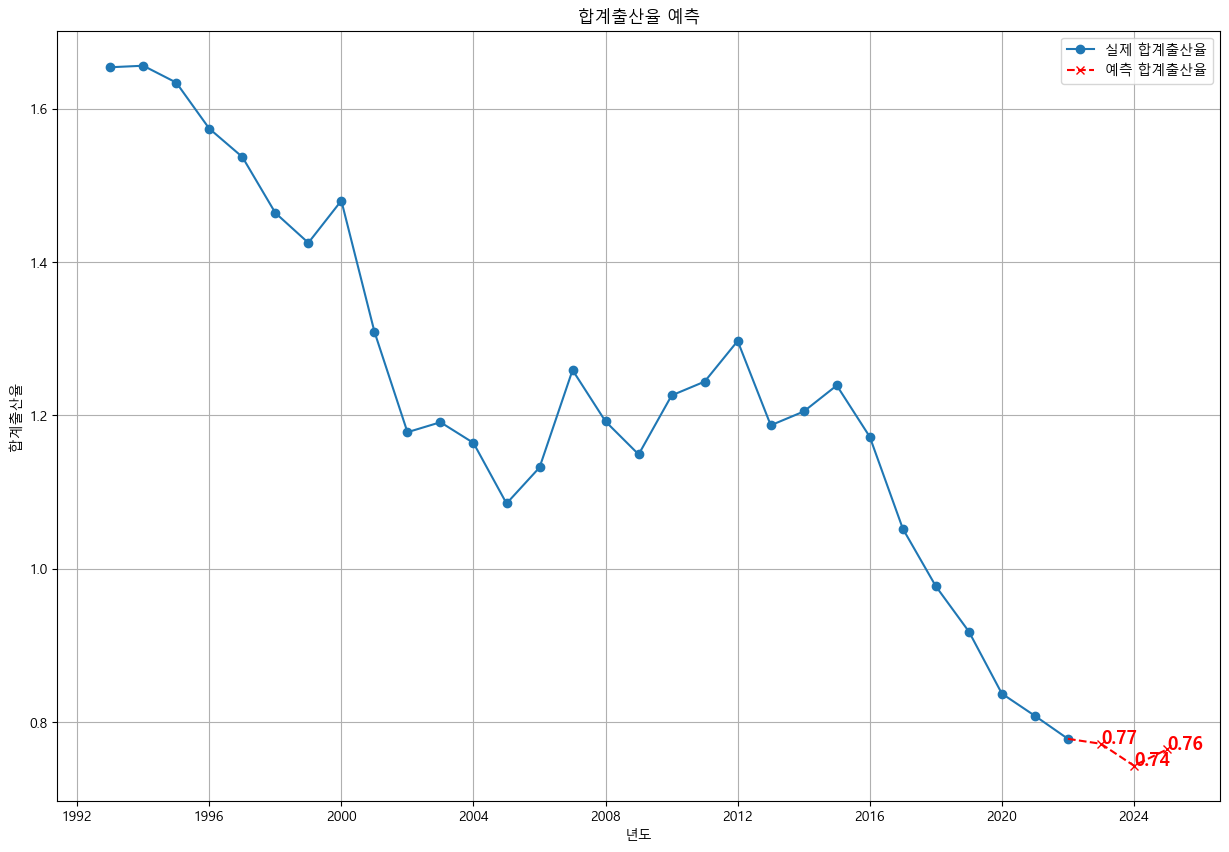

In [41]:
import matplotlib.pyplot as plt

# 원본 합계출산율 데이터의 마지막 몇 년간 데이터와 예측된 합계출산율 데이터를 시각화합니다.
plt.figure(figsize=(15, 10))

# 원본 데이터 시각화
plt.plot(df.index, df['합계출산율'], label='실제 합계출산율', marker='o')

# 예측된 합계출산율 데이터
# 예측된 합계출산율 데이터를 누적하여 시각화하기 위해 누적 차분을 계산합니다.
predicted_total_fertility_rate = forecast_df['합계출산율_diff1'].cumsum() + df['합계출산율'].iloc[-1]
predicted_dates = predicted_total_fertility_rate.index

# 예측된 값에 대해 수치 표시
for date, value in zip(predicted_dates, predicted_total_fertility_rate):
    plt.text(date, value, f"{value:.2f}", color='red', weight='bold', fontsize=13)
plt.plot(predicted_dates, predicted_total_fertility_rate, label='예측 합계출산율', color='red', marker='x', linestyle='--')
# 실제 값의 마지막 점과 예측 값의 시작하는 점을 이어주는 선 추가
plt.plot(
    [df.index[-1], predicted_dates[0]], 
    [df['합계출산율'].iloc[-1], predicted_total_fertility_rate.iloc[0]], 
    color='red', 
    linestyle='--'
)

# 그래프 제목과 축 라벨 설정
plt.title('합계출산율 예측')
plt.xlabel('년도')
plt.ylabel('합계출산율')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()


---

---

ARIMA 예측

In [42]:
df_series = df['합계출산율']
df_series.columns = ['borth_rate']

<AxesSubplot:xlabel='Year'>

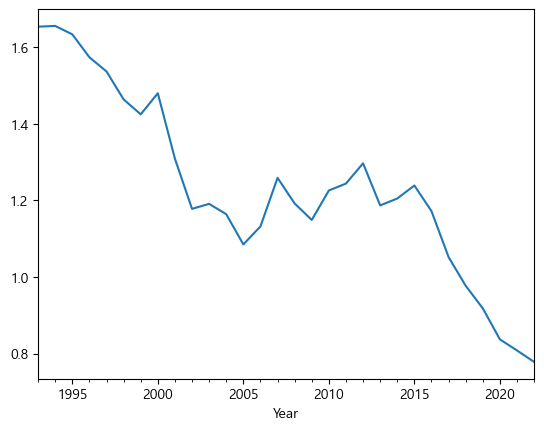

In [43]:
df_series.plot()

ADF 통계량: -0.565757
p-value: 0.878533
첫 번째 차분 적용
차분 후 ADF 통계량: -4.764055
차분 후 p-value: 0.000064
첫 번째 차분 후 시계열 정상성 만족


<AxesSubplot:xlabel='Year'>

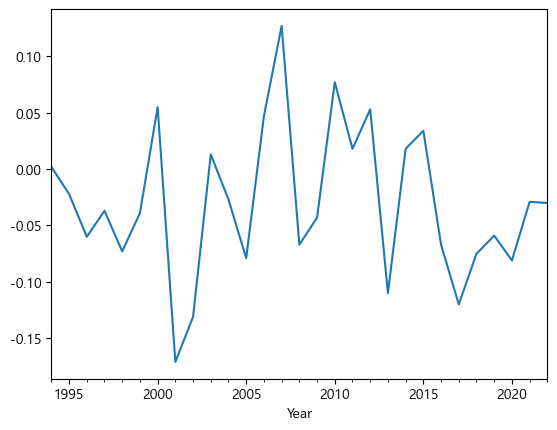

In [44]:
from statsmodels.tsa.stattools import adfuller

# ADF 테스트 실행
result = adfuller(df_series)
print('ADF 통계량: %f' % result[0])
print('p-value: %f' % result[1])

# p-value가 0.05보다 크면, 차분 실행
if result[1] > 0.05:
    df_series_diff = df_series.diff().dropna()
    print('첫 번째 차분 적용')

    # 차분 후 다시 ADF 테스트 실행
    result_diff = adfuller(df_series_diff)
    print('차분 후 ADF 통계량: %f' % result_diff[0])
    print('차분 후 p-value: %f' % result_diff[1])
    if result_diff[1] > 0.05:
        print('첫 번째 차분 후 시계열이 비정상성 시계열')
    else:
        print('첫 번째 차분 후 시계열 정상성 만족')
else:
    print('차분 필요 없음')
    df_series_diff = df_series

# 차분 후의 시계열 데이터 시각화
df_series_diff.plot()

c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


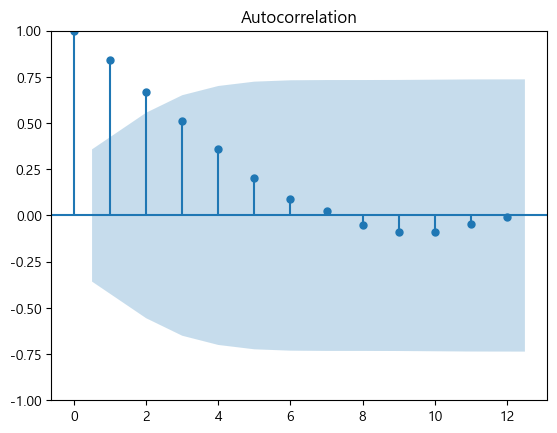

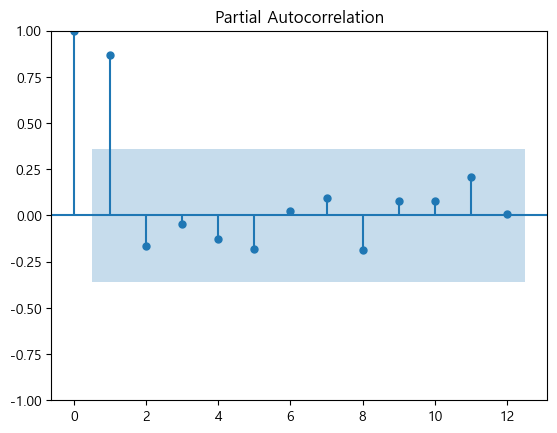

<Figure size 1000x600 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 및 PACF 그래프 시각화 (신뢰구간 안에 들어가는 값으로 판단)
plot_acf(df_series, lags=12) # MA -> 3
plot_pacf(df_series, lags=12) # AR -> 2
plt.figure(figsize=(10, 6))
plt.show()

In [46]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_series, order=(3, 1, 2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  합계출산율   No. Observations:                   30
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  39.570
Date:                Tue, 28 May 2024   AIC                            -67.140
Time:                        13:10:45   BIC                            -58.936
Sample:                    01-01-1993   HQIC                           -64.570
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6326      0.303      2.086      0.037       0.038       1.227
ar.L2         -0.5452      0.292     -1.866      0.062      -1.118       0.027
ar.L3          0.5038      0.200      2.513      0.0

c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [47]:
fore = model_fit.forecast(steps=3)
print(fore)

2023-01-01    0.748542
2024-01-01    0.730256
2025-01-01    0.719634
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [48]:
df_series.tail()

Year
2018-01-01    0.977
2019-01-01    0.918
2020-01-01    0.837
2021-01-01    0.808
2022-01-01    0.778
Name: 합계출산율, dtype: float64

c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\juneh\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


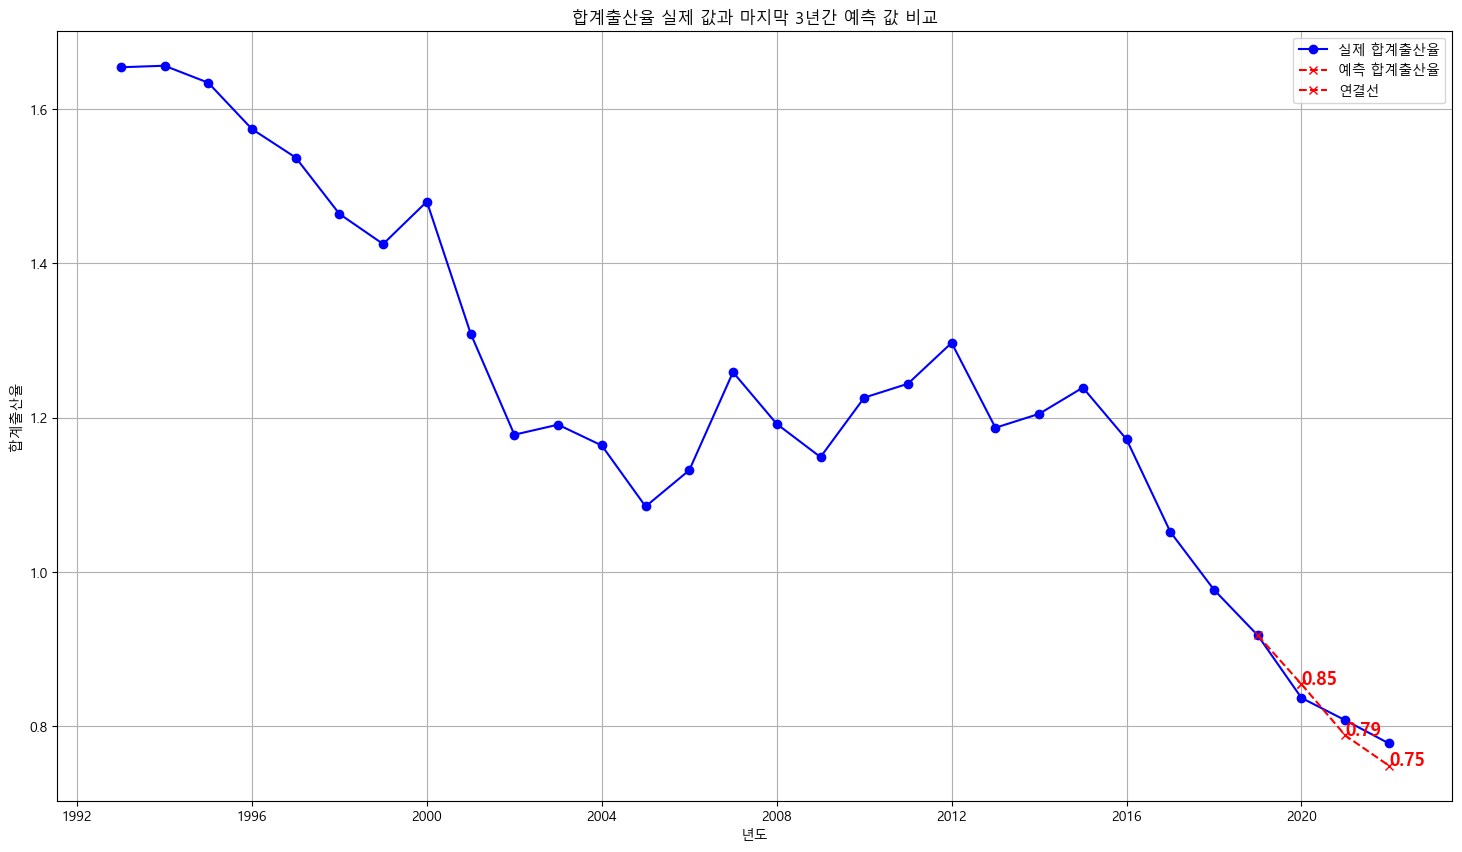

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# 마지막 3개의 값을 제거한 데이터
train_series = df_series[:-3]

# 모델 학습
model = ARIMA(train_series, order=(3, 1, 2))
model_fit = model.fit()

# 마지막 3개의 값 예측
forecast = model_fit.forecast(steps=3)
forecast_dates = df_series.index[-3:]

# 예측 결과를 시리즈로 변환
forecast_series = pd.Series(forecast, index=forecast_dates)

# 실제 마지막 값과 예측 첫 값 연결을 위한 데이터 추출
last_actual_value = df_series.iloc[-4]  # 마지막 3개 이전의 실제 값
first_forecast_value = forecast_series.iloc[0]
last_actual_date = df_series.index[-4]
first_forecast_date = forecast_series.index[0]

# 그래프 설정
plt.figure(figsize=(18, 10))

# 실제 합계출산율 데이터 시각화 (전체 데이터)
plt.plot(df_series.index, df_series, label='실제 합계출산율', marker='o', color='blue')

# 예측된 합계출산율 데이터 시각화
plt.plot(forecast_series.index, forecast_series, label='예측 합계출산율', marker='x', linestyle='--', color='red')

# 실제 마지막 값과 예측 첫 값 연결
plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color='red', linestyle='--', marker='x', label='연결선')

# 예측된 값에 대해 수치 표시
for date, value in zip(forecast_series.index, forecast_series):
    plt.text(date, value, f"{value:.2f}", color='red', weight='bold', fontsize=13)

# 실제 값과 예측 값의 비교를 위한 그래프 세부 설정
plt.title('합계출산율 실제 값과 마지막 3년간 예측 값 비교')
plt.xlabel('년도')
plt.ylabel('합계출산율')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()


In [50]:
# 실제 마지막 3개 값
actual_values = df_series[-3:]

# MAPE 계산
mape = np.mean(np.abs(actual_values - forecast_series) / actual_values) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 2.75%


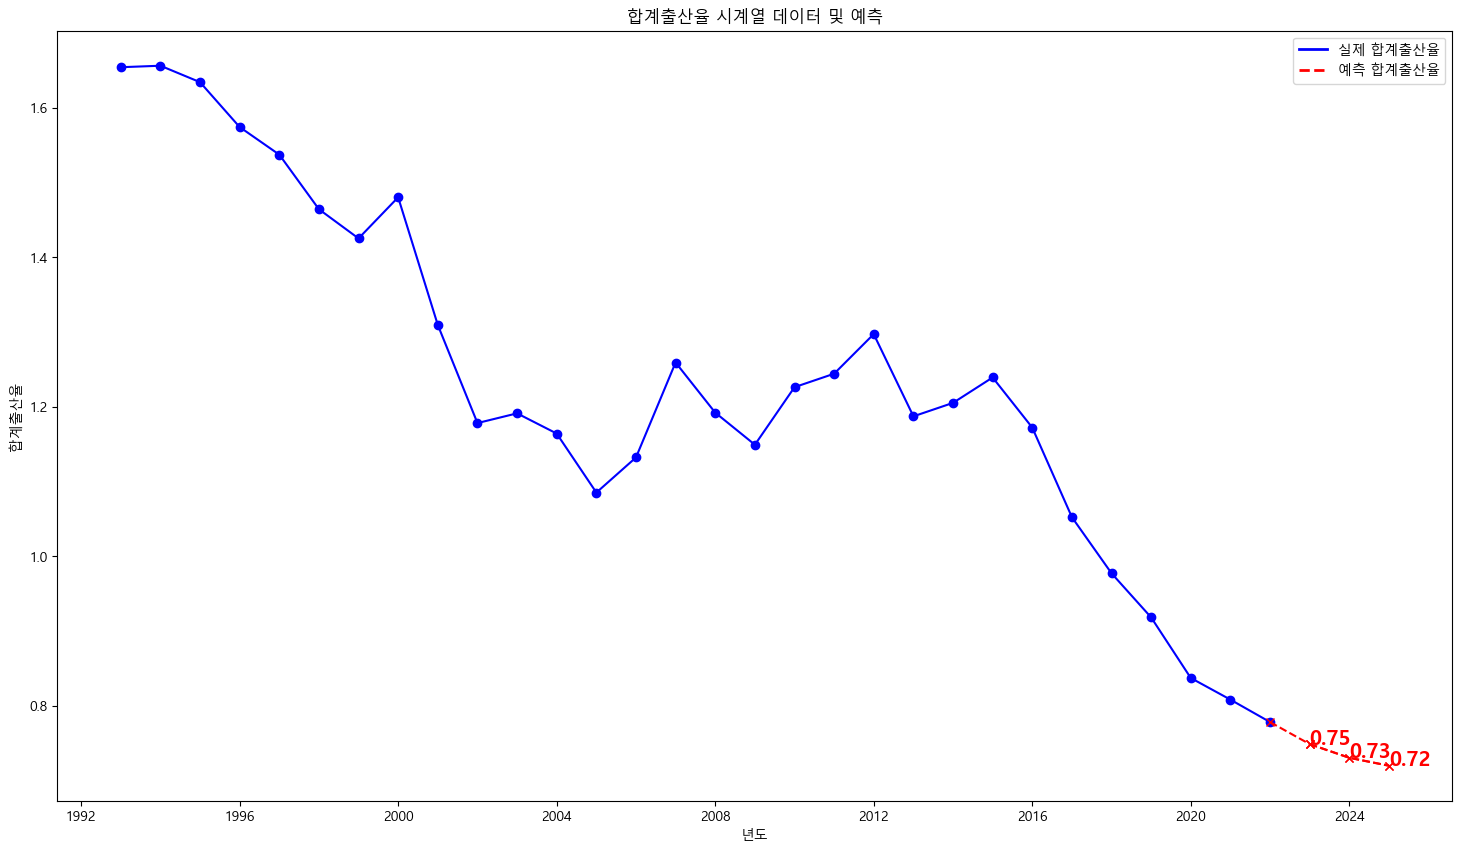

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 원본 데이터와 예측 데이터를 하나의 DataFrame으로 결합합니다.
combined_df = pd.concat([df_series, fore])

# 그래프로 시각화합니다.
plt.figure(figsize=(18, 10))
plt.plot(df_series.index, df_series, marker='o', linestyle='-', color='blue')
plt.plot(fore.index, fore, marker='x', linestyle='--', color='red')

# 그래프에 타이틀과 레이블을 추가합니다.
plt.title('합계출산율 시계열 데이터 및 예측')
plt.xlabel('년도')
plt.ylabel('합계출산율')

# 범례 항목을 정의합니다.
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='실제 합계출산율'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='예측 합계출산율')
]

# 범례를 추가합니다.
plt.legend(handles=legend_elements)

# 예측값의 각 점 위에 수치 표시
for x, y in zip(fore.index, fore):
    plt.text(x, y, f'{y:.2f}', color='red', weight='bold', fontsize=15)
plt.plot(fore.index, fore, label='예측 합계출산율', color='red', marker='x', linestyle='--')


# 실제값의 마지막 점과 예측값의 첫 번째 점을 구합니다.
last_actual_point = df_series.iloc[-1]
first_forecast_point = fore.iloc[0]

# 이 두 점을 연결하는 선을 그립니다.
plt.plot([df_series.index[-1], fore.index[0]], [last_actual_point, first_forecast_point], color='red', linestyle='--', marker='x')


# 그래프를 표시합니다.
plt.show()


.